In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
#!pip install jupyterlab-execute-time

In [3]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import explode, from_unixtime, col, to_date, sum, avg, to_utc_timestamp, udf
from pyspark.sql.types import DateType, TimestampType, StructType, StructField, StringType, IntegerType

In [4]:
import requests
import json
from collections import defaultdict
import locale
import os
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

Importing plotly failed. Interactive plots will not work.


In [5]:
# 1. Initialize SparkSession
# This is the entry point to Spark functionality.
spark = SparkSession.builder \
    .appName("SimplePySparkExample") \
    .config("spark.jars", "jars/postgresql-42.7.7.jar") \
    .config("spark.sql.sources.partitionOverwriteMode", "dynamic") \
    .getOrCreate()

# # 3. Perform a basic operation (e.g., show the DataFrame)
# # The show() method displays the content of the DataFrame.
# df.show()

In [27]:
# Load auxiliary table
df_parks = spark.read.json('general_schemas_tables/park_by_entity_meta.json')

In [28]:
DB_URL = "jdbc:postgresql://postgres:5432/themeparkwizard"
PROPERTIES_CUSTOM = {"user": os.environ['POSTGRES_USER'],"password": os.environ['POSTGRES_PASSWORD'], "driver": "org.postgresql.Driver"}

In [29]:
df_parks.write.option("truncate", True).jdbc(url=DB_URL, table=f"themeparkwizard.dim_park_entity", mode='overwrite', properties=PROPERTIES_CUSTOM)

Py4JJavaError: An error occurred while calling o79.jdbc.
: java.lang.ClassNotFoundException: org.postgresql.Driver
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:592)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:525)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:46)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:103)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:246)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:250)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:47)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:48)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:859)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:388)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:361)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:248)
	at org.apache.spark.sql.DataFrameWriter.jdbc(DataFrameWriter.scala:756)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)


In [20]:
df_parks.show()

+--------------------+--------------------+--------------------+-------------+--------------+------------------+----------------+----------+
|           entity_id|         entity_name|                  id|     latitude|     longitude|              name|        timezone|      type|
+--------------------+--------------------+--------------------+-------------+--------------+------------------+----------------+----------+
|796b0a25-c51e-456...|       Jungle Cruise|75ea578a-adc8-411...|  28.41797818|-81.5834393157|Magic Kingdom Park|America/New_York|ATTRACTION|
|6fd1e225-53a0-4a8...|Walt Disney's Enc...|75ea578a-adc8-411...|28.4182264646| -81.583738382|Magic Kingdom Park|America/New_York|ATTRACTION|
|924a3b2c-6b4b-49e...|     The Barnstormer|75ea578a-adc8-411...|28.4207661576|-81.5783907473|Magic Kingdom Park|America/New_York|ATTRACTION|
|e40ac396-cbac-43f...|Walt Disney World...|75ea578a-adc8-411...|    28.420934|    -81.578368|Magic Kingdom Park|America/New_York|ATTRACTION|
|f010bc01-b45

In [8]:
df_parks.printSchema()

root
 |-- entity_id: string (nullable = true)
 |-- entity_name: string (nullable = true)
 |-- id: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- type: string (nullable = true)



In [14]:
# df = spark.read.json('raw_folder/animal_kingdom/2507-2607/')

In [15]:
with open('general_schemas_tables/raw_schema.json', 'r') as f:
    raw_schema_obj = StructType.fromJson(json.load(f))
    # json.dump(raw_schema, f, indent=4)

In [19]:
df = spark.read.schema(raw_schema_obj).json('raw_layer/animal_kingdom/**')

In [20]:
df.show(truncate=False)

+----------+------------+--------+------------------------------------+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
df.count()

1917

In [22]:
raw_schema = df.schema.jsonValue()

In [23]:
raw_schema['fields'] = [e for e in raw_schema.get('fields') if e.get('name') != '_corrupt_record']

In [24]:
# with open('raw_schema.json', 'w') as f:
#     json.dump(raw_schema, f, indent=4)

In [25]:
# raw_schema_obj = StructType.fromJson(raw_schema)

In [26]:
raw_schema_obj

StructType([StructField('entityType', StringType(), True), StructField('extracted_at', LongType(), True), StructField('forecast', ArrayType(StructType([StructField('percentage', LongType(), True), StructField('time', TimestampType(), True), StructField('waitTime', LongType(), True)]), True), True), StructField('id', StringType(), True), StructField('lastUpdated', StringType(), True), StructField('liveData', ArrayType(StructType([StructField('diningAvailability', ArrayType(StructType([StructField('partySize', LongType(), True), StructField('waitTime', LongType(), True)]), True), True), StructField('entityType', StringType(), True), StructField('forecast', ArrayType(StructType([StructField('percentage', LongType(), True), StructField('time', TimestampType(), True), StructField('waitTime', LongType(), True)]), True), True), StructField('id', StringType(), True), StructField('lastUpdated', StringType(), True), StructField('name', StringType(), True), StructField('operatingHours', ArrayType

In [27]:
TimestampType().json()

'"timestamp"'

In [28]:
SELECTED_FEATURES = [
    col('name').alias('park_name'),
    'extracted_at',
    col('extracted_at').cast(TimestampType()).alias('extracted_at_time'),
    to_date('extracted_at_time').alias('extracted_date'),
    explode('liveData').alias('live_data')
]

In [29]:
df = df.drop_duplicates()
df_features = df.select(*SELECTED_FEATURES)
print(df_features.columns)
df_features = df_features.select(*[c+'.*' if c == 'live_data' else c for c in df_features.columns])\
                        .withColumnRenamed('entityType', 'entity_type')\
                        .where("entity_type != 'PARK' AND extracted_date IS NOT NULL")

['park_name', 'extracted_at', 'extracted_at_time', 'extracted_date', 'live_data']


In [30]:
df.count()

1403

In [31]:
df_features.count()

54717

In [32]:
df_features.printSchema()

root
 |-- park_name: string (nullable = true)
 |-- extracted_at: long (nullable = true)
 |-- extracted_at_time: timestamp (nullable = true)
 |-- extracted_date: date (nullable = true)
 |-- diningAvailability: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- partySize: long (nullable = true)
 |    |    |-- waitTime: long (nullable = true)
 |-- entity_type: string (nullable = true)
 |-- forecast: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- percentage: long (nullable = true)
 |    |    |-- time: timestamp (nullable = true)
 |    |    |-- waitTime: long (nullable = true)
 |-- id: string (nullable = true)
 |-- lastUpdated: string (nullable = true)
 |-- name: string (nullable = true)
 |-- operatingHours: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- endTime: timestamp (nullable = true)
 |    |    |-- startTime: timestamp (nullable = true)
 |    |    |-- type: string (null

In [33]:
df_features.join(df_parks, df_features.id == df_parks.entity_id).show(30, truncate=False)

+----------------------------------+------------+-------------------+--------------+------------------------------------------------------------------------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+--------------------+-----------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Using Spark dataframe
df_features.where("live_data.entityType = 'ATTRACTION'")\
            .groupBy("extracted_date", "name") \
            .agg(avg("queue.STANDBY.waitTime").alias("total_value_per_day")) \
            .orderBy("extracted_date")\
            .where("total_value_per_day is not null")\
            .show(400, truncate=False)

In [ ]:
df_features.write\
            .mode('overwrite')\
            .partitionBy('entity_type', 'extracted_date')\
            .orc('./results/animal_kingdom_silver')

In [9]:
df_dl = spark.read.orc('datalake_layer/epcot')

In [10]:
df_dl.count()

277832

In [11]:
df_dl.groupBy('entity_type', 'extracted_date').count().show(50, truncate=False)

+-----------+--------------+-----+
|entity_type|extracted_date|count|
+-----------+--------------+-----+
|ATTRACTION |2025-08-12    |5874 |
|ATTRACTION |2025-07-28    |10230|
|ATTRACTION |2025-08-02    |10758|
|ATTRACTION |2025-08-08    |6006 |
|ATTRACTION |2025-08-04    |5874 |
|ATTRACTION |2025-08-13    |5874 |
|ATTRACTION |2025-08-07    |5874 |
|ATTRACTION |2025-07-31    |19503|
|ATTRACTION |2025-07-29    |8316 |
|ATTRACTION |2025-08-06    |5709 |
|ATTRACTION |2025-08-03    |4785 |
|ATTRACTION |2025-08-11    |5874 |
|ATTRACTION |2025-08-05    |5478 |
|ATTRACTION |2025-08-10    |5874 |
|ATTRACTION |2025-07-26    |5742 |
|ATTRACTION |2025-08-09    |5874 |
|ATTRACTION |2025-08-01    |5874 |
|ATTRACTION |2025-07-25    |4620 |
|ATTRACTION |2025-07-30    |6006 |
|ATTRACTION |2025-07-27    |3564 |
|SHOW       |2025-07-31    |13002|
|SHOW       |2025-08-02    |7172 |
|SHOW       |2025-07-29    |5544 |
|SHOW       |2025-08-11    |4094 |
|SHOW       |2025-07-28    |6820 |
|SHOW       |2025-08

In [12]:
df_dl.createOrReplaceTempView('datalake_table')

In [13]:
# df_features.where("live_data.entityType = 'ATTRACTION'")\
#             .groupBy("extracted_date", "name") \
#             .agg(avg("queue.STANDBY.waitTime").alias("total_value_per_day")) \
#             .orderBy("extracted_date")\
#             .where("total_value_per_day is not null")\
#             .show(400, truncate=False)

# Using Spark SQL
test_df = spark.sql("""
SELECT 
    extracted_date,
    name AS attraction_name, 
    AVG(queue.STANDBY.waitTime) AS avg_standby_waittime
FROM datalake_table
WHERE entity_type = 'ATTRACTION' AND queue.STANDBY.waitTime is not null
GROUP BY 1, 2
ORDER BY 1
""")

In [14]:
test_df.show(50, truncate=False)

+--------------+----------------------------------------------+--------------------+
|extracted_date|attraction_name                               |avg_standby_waittime|
+--------------+----------------------------------------------+--------------------+
|2025-07-25    |The Seas with Nemo & Friends                  |11.185185185185185  |
|2025-07-25    |Spaceship Earth                               |14.11111111111111   |
|2025-07-25    |Mission: SPACE                                |18.62962962962963   |
|2025-07-25    |Soarin' Around the World                      |28.1203007518797    |
|2025-07-25    |Frozen Ever After                             |60.55555555555556   |
|2025-07-25    |Living with the Land                          |12.706766917293233  |
|2025-07-25    |Journey Into Imagination With Figment         |10.03875968992248   |
|2025-07-25    |Turtle Talk With Crush                        |15.0                |
|2025-07-25    |Remy's Ratatouille Adventure                  |50

In [15]:
test_df.printSchema()

root
 |-- extracted_date: date (nullable = true)
 |-- attraction_name: string (nullable = true)
 |-- avg_standby_waittime: double (nullable = true)



In [29]:
# prop_jdbc = {"user": "postgres","password": "postgres", "driver": "org.postgresql.Driver"}
# test_df.write.jdbc(url="jdbc:postgresql://postgres:5432/postgres", table="agg_avg_time_epcot", mode='overwrite', properties=prop_jdbc)

In [6]:
df_dl = spark.read.orc('datalake_layer/epcot')
df_dl.printSchema()


root
 |-- park_name: string (nullable = true)
 |-- extracted_at: long (nullable = true)
 |-- extracted_at_time: timestamp (nullable = true)
 |-- diningAvailability: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- partySize: long (nullable = true)
 |    |    |-- waitTime: long (nullable = true)
 |-- forecast: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- percentage: long (nullable = true)
 |    |    |-- time: timestamp (nullable = true)
 |    |    |-- waitTime: long (nullable = true)
 |-- id: string (nullable = true)
 |-- lastUpdated: string (nullable = true)
 |-- name: string (nullable = true)
 |-- operatingHours: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- endTime: timestamp (nullable = true)
 |    |    |-- startTime: timestamp (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- parkId: string (nullable = true)
 |-- queue: struct (nullable = true)

In [7]:
@udf(returnType=TimestampType())
def min_hour(data):
    if isinstance(data, list):
        for ee in data:
            if ee.type == 'Early Entry':
                return ee.startTime

@udf(returnType=TimestampType())
def max_hour(data):
    if isinstance(data, list):
        for op in data:
            if op.type == 'Operating':
                return op.endTime

In [8]:
df_dl.where("name == 'Guardians of the Galaxy: Cosmic Rewind'").count()

4707

In [9]:
df_dl.show(10)

+---------+------------+-------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+---------+-----------+--------------+
|park_name|extracted_at|  extracted_at_time|diningAvailability|            forecast|                  id|         lastUpdated|                name|      operatingHours|              parkId|               queue|showtimes|   status|entity_type|extracted_date|
+---------+------------+-------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+---------+-----------+--------------+
|    EPCOT|  1753978343|2025-07-31 16:12:23|              NULL|[{12, 2025-07-31 ...|61fb49f8-e62f-4e1...|2025-07-31T13:11:51Z|Canada Far and Wi...|[{2025-08-01 01:0...|47f90d2c-e191-423...|{NULL, NULL, NULL...|     NULL|OPERAT

In [10]:
df_dl.where("name == 'Guardians of the Galaxy: Cosmic Rewind'")\
    .withColumn('start_time', min_hour(col('operatingHours')))\
    .withColumn('end_time', max_hour(col('operatingHours')))\
    .filter(col('extracted_at_time').between(col('start_time'), col('end_time')))

DataFrame[park_name: string, extracted_at: bigint, extracted_at_time: timestamp, diningAvailability: array<struct<partySize:bigint,waitTime:bigint>>, forecast: array<struct<percentage:bigint,time:timestamp,waitTime:bigint>>, id: string, lastUpdated: string, name: string, operatingHours: array<struct<endTime:timestamp,startTime:timestamp,type:string>>, parkId: string, queue: struct<PAID_RETURN_TIME:struct<price:struct<amount:bigint,currency:string,formatted:string>,returnEnd:string,returnStart:string,state:string>,RETURN_TIME:struct<returnEnd:string,returnStart:string,state:string>,SINGLE_RIDER:struct<waitTime:string>,STANDBY:struct<waitTime:bigint>>, showtimes: array<struct<endTime:timestamp,startTime:timestamp,type:string>>, status: string, entity_type: string, extracted_date: date, start_time: timestamp, end_time: timestamp]

In [11]:
df_dl.where("name == 'Guardians of the Galaxy: Cosmic Rewind'")\
    .withColumn('start_time', min_hour(col('operatingHours')))\
    .withColumn('end_time', max_hour(col('operatingHours')))\
    .filter(col('extracted_at_time').between(col('start_time'), col('end_time')))\
    .printSchema()
    # .show(5, truncate=False, vertical=True) #.withColumn('operatingHoursUTC', to_utc_timestamp(col('operatingHours')))

root
 |-- park_name: string (nullable = true)
 |-- extracted_at: long (nullable = true)
 |-- extracted_at_time: timestamp (nullable = true)
 |-- diningAvailability: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- partySize: long (nullable = true)
 |    |    |-- waitTime: long (nullable = true)
 |-- forecast: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- percentage: long (nullable = true)
 |    |    |-- time: timestamp (nullable = true)
 |    |    |-- waitTime: long (nullable = true)
 |-- id: string (nullable = true)
 |-- lastUpdated: string (nullable = true)
 |-- name: string (nullable = true)
 |-- operatingHours: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- endTime: timestamp (nullable = true)
 |    |    |-- startTime: timestamp (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- parkId: string (nullable = true)
 |-- queue: struct (nullable = true)

In [13]:
df_dl.select('extracted_date', 'extracted_at_time').orderBy('extracted_at_time', ascending=False).limit(5).show()

+--------------+-------------------+
|extracted_date|  extracted_at_time|
+--------------+-------------------+
|    2025-08-17|2025-08-17 02:04:42|
|    2025-08-17|2025-08-17 02:04:42|
|    2025-08-17|2025-08-17 02:04:42|
|    2025-08-17|2025-08-17 02:04:42|
|    2025-08-17|2025-08-17 02:04:42|
+--------------+-------------------+



In [455]:
#.where("name == 'Guardians of the Galaxy: Cosmic Rewind' AND queue.STANDBY.waitTime is not null")\
df_dl_to_model = df_dl.where("queue.STANDBY.waitTime is not null AND name == 'Guardians of the Galaxy: Cosmic Rewind'")\
                            .withColumn('start_time', min_hour(col('operatingHours')))\
                            .withColumn('end_time', max_hour(col('operatingHours')))\
                            .filter(col('extracted_at_time').between(col('start_time'), col('end_time')))\
                            .select('extracted_at_time', 'queue.STANDBY.waitTime', 'extracted_at')
# df_dl_to_model.count()

In [456]:
from pyspark.sql.functions import year, month, dayofweek, hour, minute, date_trunc

In [457]:
df_dl_to_model.head(5)

[Row(extracted_at_time=datetime.datetime(2025, 7, 31, 16, 12, 23), waitTime=65, extracted_at=1753978343),
 Row(extracted_at_time=datetime.datetime(2025, 7, 31, 16, 13, 47), waitTime=65, extracted_at=1753978427),
 Row(extracted_at_time=datetime.datetime(2025, 7, 31, 16, 54, 48), waitTime=60, extracted_at=1753980888),
 Row(extracted_at_time=datetime.datetime(2025, 7, 31, 16, 0, 16), waitTime=60, extracted_at=1753977616),
 Row(extracted_at_time=datetime.datetime(2025, 7, 31, 16, 3, 50), waitTime=65, extracted_at=1753977830)]

In [458]:
df_dl_to_model.dtypes

[('extracted_at_time', 'timestamp'),
 ('waitTime', 'bigint'),
 ('extracted_at', 'bigint')]

In [459]:
df_dl_to_model.describe().show()

+-------+------------------+-------------------+
|summary|          waitTime|       extracted_at|
+-------+------------------+-------------------+
|  count|              2934|               2934|
|   mean|  75.4737559645535|1.754228971935242E9|
| stddev|22.268175184589666|  467670.1304243549|
|    min|                 0|         1753446904|
|    max|               225|         1755133135|
+-------+------------------+-------------------+



In [460]:
# import holidays
# from datetime import date, datetime
# cur_year = datetime.now().year

# h_us = holidays.country_holidays('US', subdiv='FL', years=[cur_year, cur_year+1])

# data = [(k, v) for k, v in h_us.items()]
# schema = StructType([
#     StructField("ds", DateType(), False),
#     StructField("holiday", StringType(), False)
# ])

# hus_df = spark.createDataFrame(data, schema)
# hus_df.show()

In [461]:
# df_dl_to_model.groupBy(date_trunc('day', 'extracted_at_time')).count().show()

In [308]:
df_dl_to_model.withColumn('year', year('extracted_at_time'))\
                                .withColumn('month', month('extracted_at_time'))\
                                .withColumn('dayofweek', dayofweek('extracted_at_time'))\
                                .withColumn('hour', hour('extracted_at_time'))\
                                .withColumn('minute', minute('extracted_at_time')).show(5)

+-------------------+--------+------------+----+-----+---------+----+------+
|  extracted_at_time|waitTime|extracted_at|year|month|dayofweek|hour|minute|
+-------------------+--------+------------+----+-----+---------+----+------+
|2025-07-31 16:12:23|      65|  1753978343|2025|    7|        5|  16|    12|
|2025-07-31 16:13:47|      65|  1753978427|2025|    7|        5|  16|    13|
|2025-07-31 16:54:48|      60|  1753980888|2025|    7|        5|  16|    54|
|2025-07-31 16:00:16|      60|  1753977616|2025|    7|        5|  16|     0|
|2025-07-31 16:03:50|      65|  1753977830|2025|    7|        5|  16|     3|
+-------------------+--------+------------+----+-----+---------+----+------+
only showing top 5 rows



In [309]:
# df_dl_to_model = df_dl_to_model.withColumn('year', year('extracted_at_time'))\
#                                 .withColumn('month', month('extracted_at_time'))\
#                                 .withColumn('dayofweek', dayofweek('extracted_at_time'))\
#                                 .withColumn('hour', hour('extracted_at_time'))\
#                                 .withColumn('minute', minute('extracted_at_time')).drop('id')

In [462]:
df_dl_to_model.createOrReplaceTempView('test_table')
df_dl_to_model = spark.sql("""
WITH enrich_data AS (
    SELECT
        cast(floor(try_divide(extracted_at, 600))*600 as timestamp) as extracted_at_time,
        AVG(waitTime) as waitTime
    FROM test_table
    GROUP BY 1
    UNION ALL
    SELECT
        extracted_at_time,
        waitTime
    FROM test_table
)
SELECT 
    ed.*,
    year(extracted_at_time) as year,
    month(extracted_at_time) as month,
    dayofweek(extracted_at_time) as dayofweek,
    hour(extracted_at_time) as hour,
    minute(extracted_at_time) as minute,
    5 as floor,
    400 as cap
FROM enrich_data ed
ORDER BY ed.extracted_at_time DESC
""")

In [383]:
df_dl_to_model.show(10)

+-------------------+--------+----+-----+---------+----+------+-----+---+
|  extracted_at_time|waitTime|year|month|dayofweek|hour|minute|floor|cap|
+-------------------+--------+----+-----+---------+----+------+-----+---+
|2025-08-14 00:58:55|    80.0|2025|    8|        5|   0|    58|    5|400|
|2025-08-14 00:53:55|    80.0|2025|    8|        5|   0|    53|    5|400|
|2025-08-14 00:50:00|    80.0|2025|    8|        5|   0|    50|    5|400|
|2025-08-14 00:48:55|    80.0|2025|    8|        5|   0|    48|    5|400|
|2025-08-14 00:43:54|    80.0|2025|    8|        5|   0|    43|    5|400|
|2025-08-14 00:40:00|    80.0|2025|    8|        5|   0|    40|    5|400|
|2025-08-14 00:38:55|    80.0|2025|    8|        5|   0|    38|    5|400|
|2025-08-14 00:33:54|    80.0|2025|    8|        5|   0|    33|    5|400|
|2025-08-14 00:30:00|    80.0|2025|    8|        5|   0|    30|    5|400|
|2025-08-14 00:28:54|    80.0|2025|    8|        5|   0|    28|    5|400|
+-------------------+--------+----+---

In [463]:
# train = df_dl_to_model.where("extracted_at <= 1754535600").drop('extracted_at')
# test = df_dl_to_model.where("extracted_at > 1754535600").drop('extracted_at')
train = df_dl_to_model.drop('extracted_at')

In [464]:
train = train.withColumnRenamed('extracted_at_time', 'ds').withColumnRenamed('waitTime', 'y').cache()#.withColumnRenamed('extracted_at_time', 'ds').withColumnRenamed('waitTime', 'y')

In [506]:
train.head(30)

[Row(ds=datetime.datetime(2025, 8, 14, 0, 58, 55), y=80.0, year=2025, month=8, dayofweek=5, hour=0, minute=58, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 14, 0, 53, 55), y=80.0, year=2025, month=8, dayofweek=5, hour=0, minute=53, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 14, 0, 50), y=80.0, year=2025, month=8, dayofweek=5, hour=0, minute=50, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 14, 0, 48, 55), y=80.0, year=2025, month=8, dayofweek=5, hour=0, minute=48, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 14, 0, 43, 54), y=80.0, year=2025, month=8, dayofweek=5, hour=0, minute=43, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 14, 0, 40), y=80.0, year=2025, month=8, dayofweek=5, hour=0, minute=40, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 14, 0, 38, 55), y=80.0, year=2025, month=8, dayofweek=5, hour=0, minute=38, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 14, 0, 33, 54), y=80.0, year=2025, month=8, dayofweek=5, hour=0

In [564]:
[e.hour for e in train.select('hour').distinct().collect()]

[12, 22, 13, 16, 20, 19, 15, 17, 23, 21, 14, 0, 18]

In [466]:
#hus_df.show()

In [507]:
model = Prophet(growth='logistic')#Prophet(holidays=hus_df.toPandas(), growth='logistic')
model.add_country_holidays(country_name='US')
model.fit(train.toPandas())

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1l35lq5/xb2x43bx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1l35lq5/kjzz3_nh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29016', 'data', 'file=/tmp/tmpq1l35lq5/xb2x43bx.json', 'init=/tmp/tmpq1l35lq5/kjzz3_nh.json', 'output', 'file=/tmp/tmpq1l35lq5/prophet_modelvlnbqgsj/prophet_model-20250815030034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:00:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:00:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [508]:
from datetime import timedelta, date, tzinfo, timezone

In [509]:
tz = timezone(timedelta(hours=-3))
now = datetime.now(tz)
# x = (now + timedelta(days=1)).date()
x = (now).date()

In [510]:
BY_MINUTES = 60*10

In [511]:
limits = df_dl.where("name == 'Guardians of the Galaxy: Cosmic Rewind'")\
    .select(min_hour(col('operatingHours')).alias('start_time'), max_hour(col('operatingHours')).alias('end_time'))\
    .limit(1)\
    .collect()[0]

In [512]:
limits

Row(start_time=datetime.datetime(2025, 7, 31, 12, 30), end_time=datetime.datetime(2025, 8, 1, 1, 0))

In [513]:
(limits.end_time - limits.start_time).seconds

45000

In [514]:
new_day = datetime(x.year, x.month, x.day, limits.start_time.hour, limits.start_time.minute)

In [515]:
new_day

datetime.datetime(2025, 8, 15, 12, 30)

In [516]:
data = [(new_day + timedelta(seconds=interval),5,400) for interval in range(0, (limits.end_time - limits.start_time).seconds, BY_MINUTES)]

In [517]:
data

[(datetime.datetime(2025, 8, 15, 12, 30), 5, 400),
 (datetime.datetime(2025, 8, 15, 12, 40), 5, 400),
 (datetime.datetime(2025, 8, 15, 12, 50), 5, 400),
 (datetime.datetime(2025, 8, 15, 13, 0), 5, 400),
 (datetime.datetime(2025, 8, 15, 13, 10), 5, 400),
 (datetime.datetime(2025, 8, 15, 13, 20), 5, 400),
 (datetime.datetime(2025, 8, 15, 13, 30), 5, 400),
 (datetime.datetime(2025, 8, 15, 13, 40), 5, 400),
 (datetime.datetime(2025, 8, 15, 13, 50), 5, 400),
 (datetime.datetime(2025, 8, 15, 14, 0), 5, 400),
 (datetime.datetime(2025, 8, 15, 14, 10), 5, 400),
 (datetime.datetime(2025, 8, 15, 14, 20), 5, 400),
 (datetime.datetime(2025, 8, 15, 14, 30), 5, 400),
 (datetime.datetime(2025, 8, 15, 14, 40), 5, 400),
 (datetime.datetime(2025, 8, 15, 14, 50), 5, 400),
 (datetime.datetime(2025, 8, 15, 15, 0), 5, 400),
 (datetime.datetime(2025, 8, 15, 15, 10), 5, 400),
 (datetime.datetime(2025, 8, 15, 15, 20), 5, 400),
 (datetime.datetime(2025, 8, 15, 15, 30), 5, 400),
 (datetime.datetime(2025, 8, 15, 1

In [518]:
schema = StructType([
    StructField("ds", TimestampType(), False),
    StructField("floor", IntegerType(), False),
    StructField("cap", IntegerType(), False),
])

In [519]:
time_to_predict = spark.createDataFrame(data, schema)

In [520]:
time_to_predict.show()

+-------------------+-----+---+
|                 ds|floor|cap|
+-------------------+-----+---+
|2025-08-15 12:30:00|    5|400|
|2025-08-15 12:40:00|    5|400|
|2025-08-15 12:50:00|    5|400|
|2025-08-15 13:00:00|    5|400|
|2025-08-15 13:10:00|    5|400|
|2025-08-15 13:20:00|    5|400|
|2025-08-15 13:30:00|    5|400|
|2025-08-15 13:40:00|    5|400|
|2025-08-15 13:50:00|    5|400|
|2025-08-15 14:00:00|    5|400|
|2025-08-15 14:10:00|    5|400|
|2025-08-15 14:20:00|    5|400|
|2025-08-15 14:30:00|    5|400|
|2025-08-15 14:40:00|    5|400|
|2025-08-15 14:50:00|    5|400|
|2025-08-15 15:00:00|    5|400|
|2025-08-15 15:10:00|    5|400|
|2025-08-15 15:20:00|    5|400|
|2025-08-15 15:30:00|    5|400|
|2025-08-15 15:40:00|    5|400|
+-------------------+-----+---+
only showing top 20 rows



In [521]:
res = spark.createDataFrame(model.predict(time_to_predict.toPandas()))

In [522]:
res.select('ds', 'trend', 'yhat').show(60)

+-------------------+------------------+------------------+
|                 ds|             trend|              yhat|
+-------------------+------------------+------------------+
|2025-08-15 12:30:00|131.91141394333994|10.833544356401177|
|2025-08-15 12:40:00|131.85711202639703|13.441630426270976|
|2025-08-15 12:50:00|131.80282235419838| 16.33369688855484|
|2025-08-15 13:00:00| 131.7485449333899|19.383282632331344|
|2025-08-15 13:10:00| 131.6942797706095|22.475902530720248|
|2025-08-15 13:20:00|131.64002687248757|25.510746790639985|
|2025-08-15 13:30:00| 131.5857862456462|28.401910682394373|
|2025-08-15 13:40:00|131.53155789669987|31.079147811441487|
|2025-08-15 13:50:00| 131.4773418322551| 33.48815359508288|
|2025-08-15 14:00:00|131.42313805891058|35.590398579952605|
|2025-08-15 14:10:00|131.36894658325707|37.362543082100345|
|2025-08-15 14:20:00| 131.3147674118775|38.795475142788675|
|2025-08-15 14:30:00|131.26060055134693| 39.89302279893661|
|2025-08-15 14:40:00| 131.2064460082325|

In [523]:
res.select(avg('yhat')).show()

+------------------+
|         avg(yhat)|
+------------------+
|43.176896172693226|
+------------------+



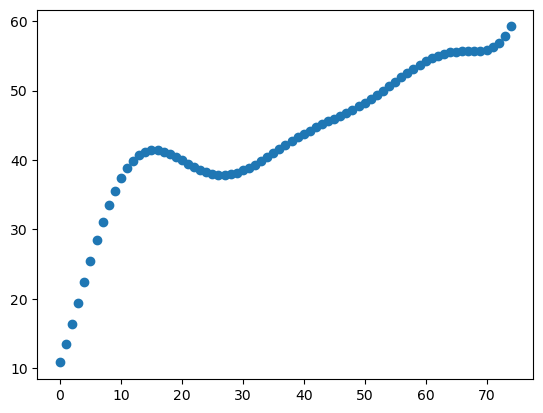

In [524]:
vis = res.toPandas()
#vis2 = df_dl_to_model.toPandas()
range_v = 00
plt.plot([range_v+e for e in vis.index], vis.yhat, 'o')
#plt.plot(vis2.index[-range_v:]-vis2.index[-range_v], vis2.waitTime[-range_v:])
plt.show()

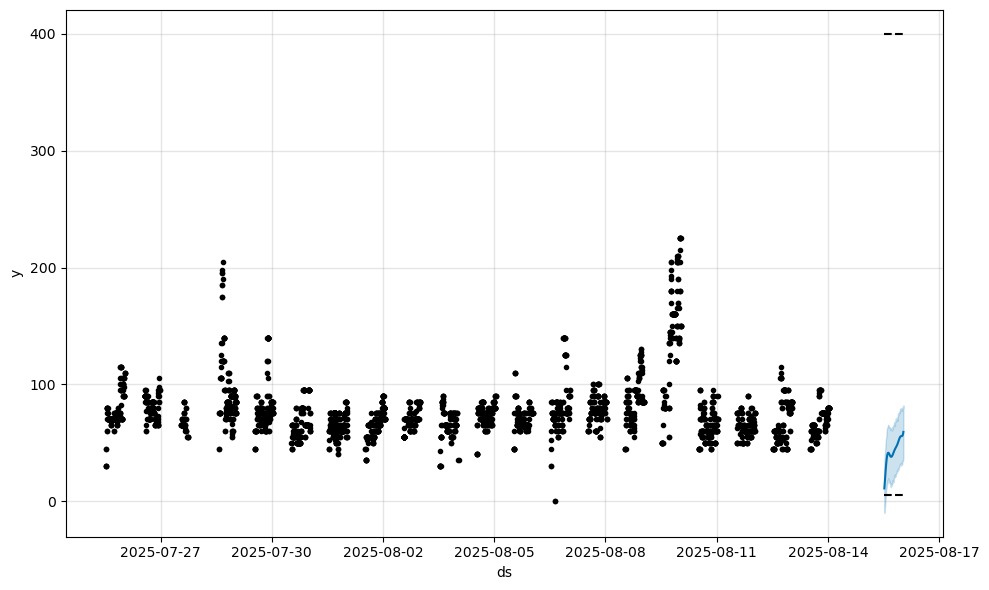

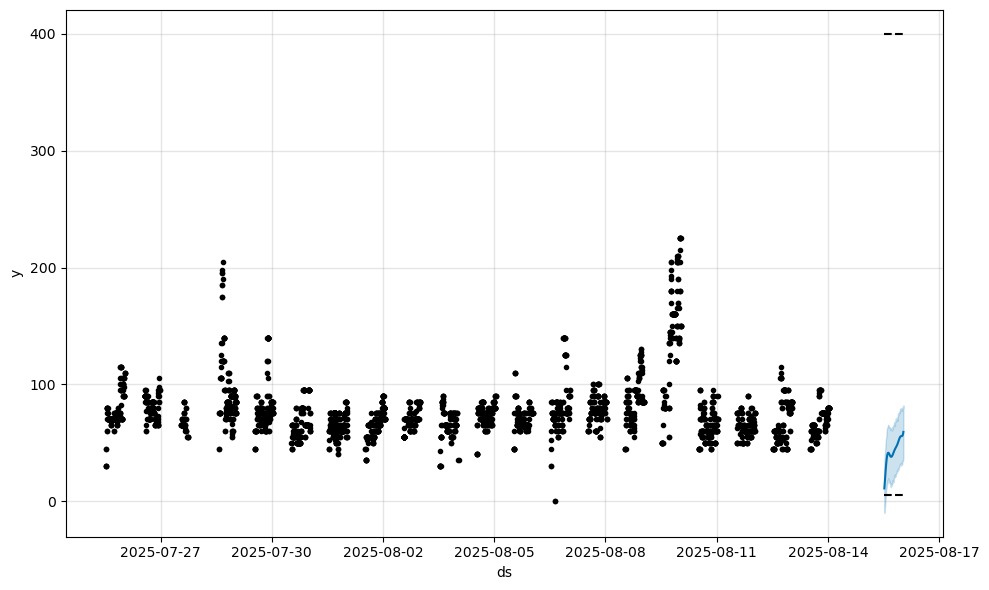

In [525]:
model.plot(res.toPandas())

In [566]:
res.select('ds', 'trend', 'yhat').printSchema()

root
 |-- ds: timestamp (nullable = true)
 |-- trend: double (nullable = true)
 |-- yhat: double (nullable = true)



In [528]:
# Python
def warm_start_params(m):
    """
    Retrieve parameters from a trained model in the format used to initialize a new Stan model.
    Note that the new Stan model must have these same settings:
        n_changepoints, seasonality features, mcmc sampling
    for the retrieved parameters to be valid for the new model.

    Parameters
    ----------
    m: A trained model of the Prophet class.

    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0][0]
        else:
            res[pname] = np.mean(m.params[pname])
    for pname in ['delta', 'beta']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0]
        else:
            res[pname] = np.mean(m.params[pname], axis=0)
    return res

df1 = train.where("ds < '2025-08-13 10:00:00'")  # All data except the last day

In [540]:
df1.head(20)

[Row(ds=datetime.datetime(2025, 8, 13, 0, 53, 39), y=80.0, year=2025, month=8, dayofweek=4, hour=0, minute=53, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 13, 0, 50), y=80.0, year=2025, month=8, dayofweek=4, hour=0, minute=50, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 13, 0, 48, 39), y=85.0, year=2025, month=8, dayofweek=4, hour=0, minute=48, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 13, 0, 43, 38), y=85.0, year=2025, month=8, dayofweek=4, hour=0, minute=43, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 13, 0, 40), y=85.0, year=2025, month=8, dayofweek=4, hour=0, minute=40, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 13, 0, 38, 38), y=85.0, year=2025, month=8, dayofweek=4, hour=0, minute=38, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 13, 0, 33, 38), y=85.0, year=2025, month=8, dayofweek=4, hour=0, minute=33, floor=5, cap=400),
 Row(ds=datetime.datetime(2025, 8, 13, 0, 30), y=85.0, year=2025, month=8, dayofweek=4, hour=0, mi

In [529]:
m1 = Prophet().fit(df1.toPandas()) # A model fit to all data except the last day

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1l35lq5/rot01nd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1l35lq5/3wfttc_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58649', 'data', 'file=/tmp/tmpq1l35lq5/rot01nd6.json', 'init=/tmp/tmpq1l35lq5/3wfttc_9.json', 'output', 'file=/tmp/tmpq1l35lq5/prophet_modelamnyyu5g/prophet_model-20250815030602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:06:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:06:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [533]:
m2 = Prophet().fit(train.toPandas())  # Adding the last day, fitting from scratch

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1l35lq5/nfzm8l9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1l35lq5/n7osuv34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97665', 'data', 'file=/tmp/tmpq1l35lq5/nfzm8l9y.json', 'init=/tmp/tmpq1l35lq5/n7osuv34.json', 'output', 'file=/tmp/tmpq1l35lq5/prophet_model7rz_zy2w/prophet_model-20250815030719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:07:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:07:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [534]:
m3 = Prophet().fit(train.toPandas(), init=warm_start_params(m1))  # Adding the last day, warm-starting from m1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1l35lq5/im93un0e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1l35lq5/tetsa_qe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/conda/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85557', 'data', 'file=/tmp/tmpq1l35lq5/im93un0e.json', 'init=/tmp/tmpq1l35lq5/tetsa_qe.json', 'output', 'file=/tmp/tmpq1l35lq5/prophet_modelnslx3gz0/prophet_model-20250815030724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:07:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:07:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


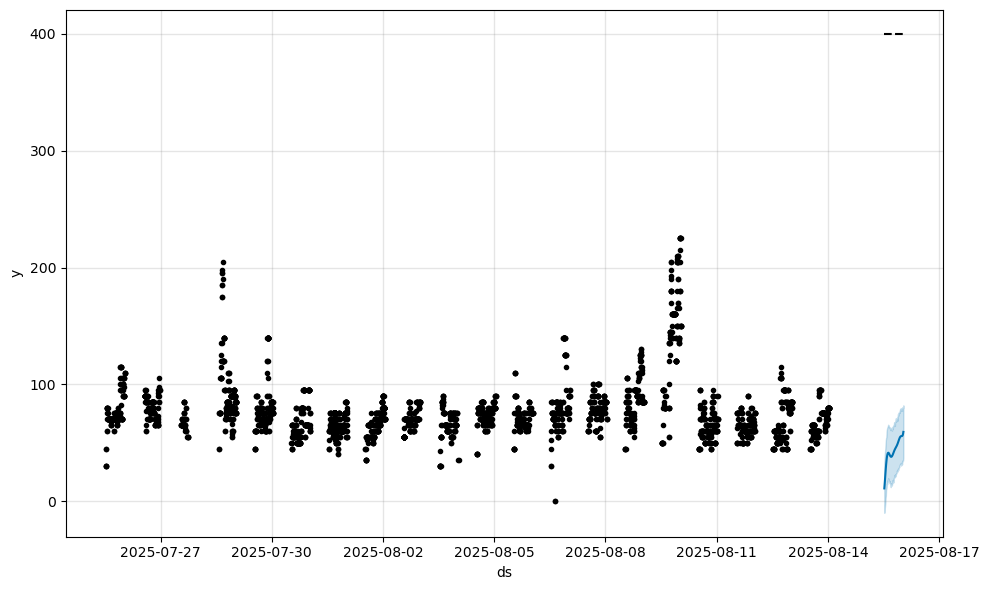

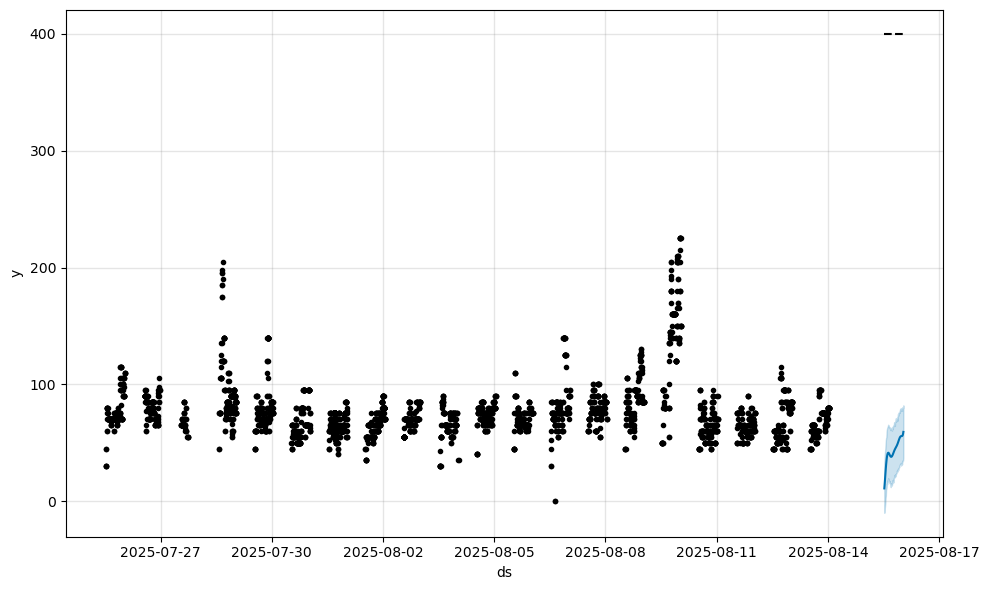

In [538]:
m2.plot(res.toPandas())

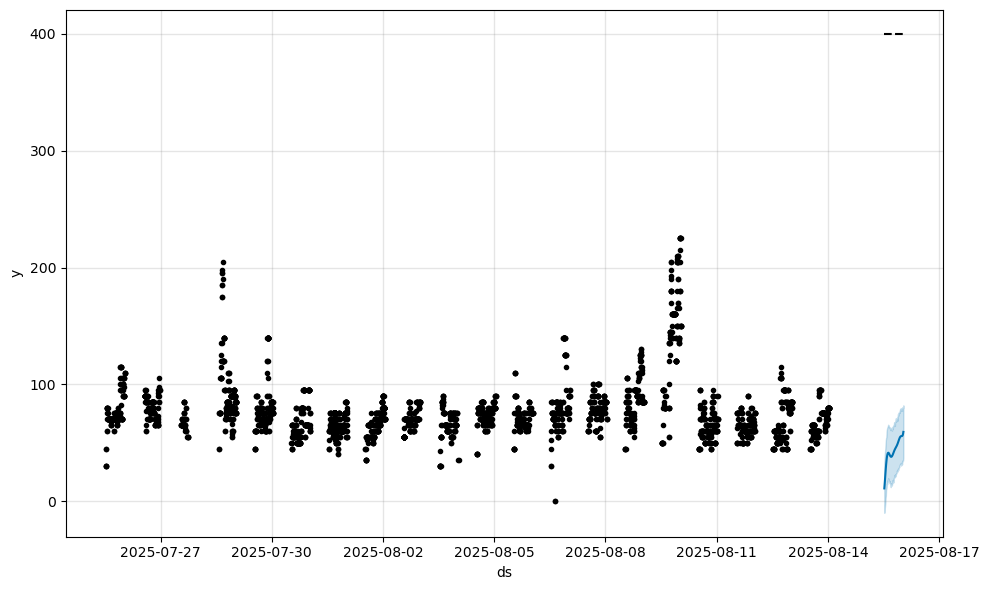

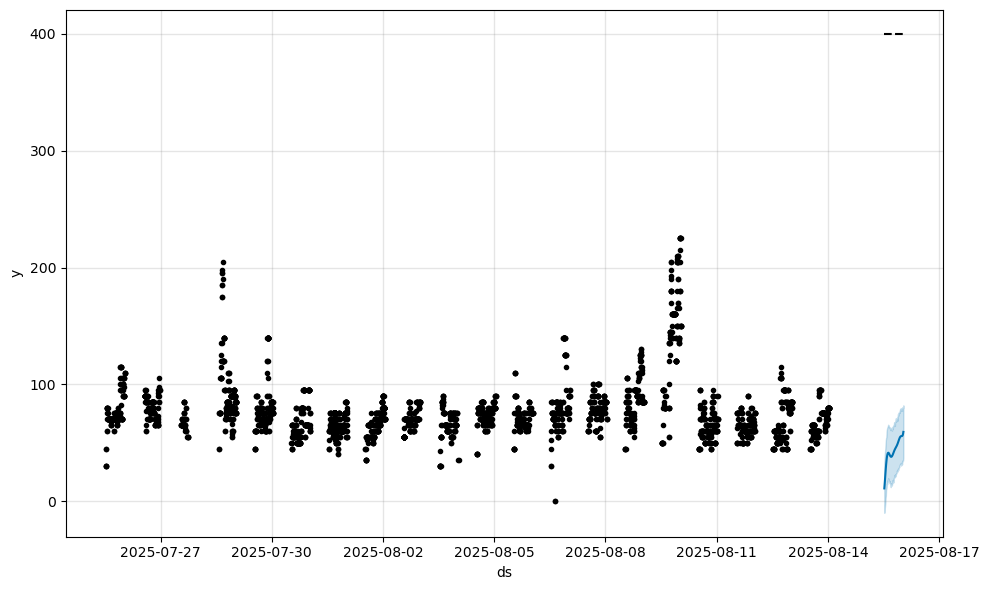

In [539]:
m3.plot(res.toPandas())

In [541]:
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m1))  # Save model

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

In [558]:
[i == j for i, j in zip(m1.params, m.params)]

[True, True, True, True, True, True, True]

In [546]:
m

In [180]:
test_forecast = model.predict(df=test.withColumnRenamed('ten_min', 'ds').withColumnRenamed('waitTime', 'y').toPandas())

In [181]:
t_fore = spark.createDataFrame(test_forecast)

In [182]:
t_fore.printSchema()

root
 |-- ds: timestamp (nullable = true)
 |-- trend: double (nullable = true)
 |-- yhat_lower: double (nullable = true)
 |-- yhat_upper: double (nullable = true)
 |-- trend_lower: double (nullable = true)
 |-- trend_upper: double (nullable = true)
 |-- additive_terms: double (nullable = true)
 |-- additive_terms_lower: double (nullable = true)
 |-- additive_terms_upper: double (nullable = true)
 |-- daily: double (nullable = true)
 |-- daily_lower: double (nullable = true)
 |-- daily_upper: double (nullable = true)
 |-- multiplicative_terms: double (nullable = true)
 |-- multiplicative_terms_lower: double (nullable = true)
 |-- multiplicative_terms_upper: double (nullable = true)
 |-- yhat: double (nullable = true)



In [183]:
df_dl_to_model.printSchema()

root
 |-- extracted_at_time: timestamp (nullable = true)
 |-- waitTime: long (nullable = true)
 |-- extracted_at: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- ten_min: timestamp (nullable = true)
 |-- ten_avg_wait: double (nullable = true)



In [184]:
df_dl_to_model.join(t_fore, df_dl_to_model.ten_min == t_fore.ds).where("ds is not null").show()

+-------------------+--------+------------+----+-----+---------+----+------+-------------------+------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+--------------------+--------------------------+--------------------------+------------------+
|  extracted_at_time|waitTime|extracted_at|year|month|dayofweek|hour|minute|            ten_min|ten_avg_wait|                 ds|             trend|        yhat_lower|       yhat_upper|       trend_lower|       trend_upper|    additive_terms|additive_terms_lower|additive_terms_upper|             daily|       daily_lower|       daily_upper|multiplicative_terms|multiplicative_terms_lower|multiplicative_terms_upper|              yhat|
+-------------------+--------+------------+----+-----+---------+----+------+-------------------+------------+-------------------

In [185]:
res = df_dl_to_model.join(t_fore, df_dl_to_model.ten_min == t_fore.ds).where("ds is not null")
res = res.select('ds', 'yhat', 'waitTime')

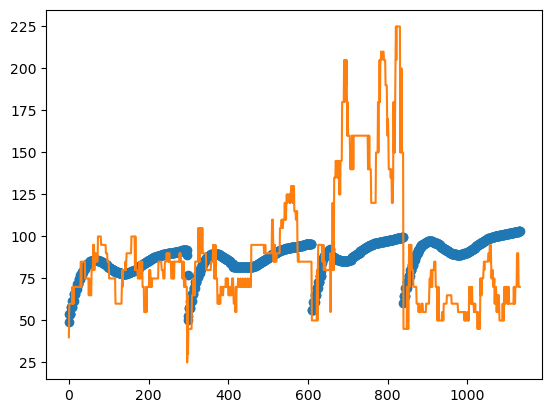

In [186]:
vis = res.toPandas()
plt.plot(vis.index, vis.yhat, 'o')
plt.plot(vis.index, vis.waitTime)
plt.show()

In [161]:
import pickle

In [162]:
with open('model.pkle', mode='ab') as f:
    pickle.dump(model, f)

with open('model.pkle', mode='rb') as f:
    model = pickle.load(f)

In [163]:
model.fit(test.toPandas())

Exception: Prophet object can only be fit once. Instantiate a new object.

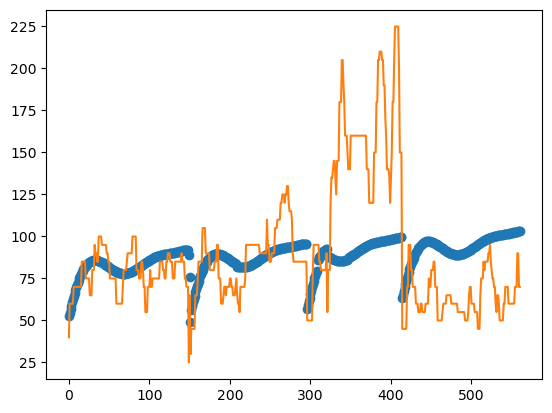

In [106]:
# Only for guardians
vis = res.toPandas()
plt.plot(vis.index, vis.yhat, 'o')
plt.plot(vis.index, vis.waitTime)
plt.show()

In [14]:
df_dl = spark.read.orc('datalake_layer/animal_kingdom').where("id = '55c531b6-3ce2-4c47-a8a1-0dc9107d825b'").cache()

In [27]:
df_dl.show(30, truncate=True)

+--------------------+------------+-------------------+------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+---------+---------+-----------+--------------+
|           park_name|extracted_at|  extracted_at_time|diningAvailability|            forecast|                  id|         lastUpdated|    name|      operatingHours|              parkId|               queue|showtimes|   status|entity_type|extracted_date|
+--------------------+------------+-------------------+------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+---------+---------+-----------+--------------+
|Disney's Animal K...|  1755116632|2025-08-13 20:23:52|              NULL|[{4, 2025-08-13 1...|55c531b6-3ce2-4c4...|2025-08-13T20:19:18Z|DINOSAUR|[{2025-08-13 12:0...|1c84a229-8862-464...|{NULL, {NULL, 202...|     NULL|OPERATING|

In [28]:
df_dl.createOrReplaceTempView('a_new_hope')

In [32]:
# spark.sql("""
# WITH status_basic AS (
# SELECT
#     extracted_date,
#     extracted_at_time,
#     id as entity_id,
#     status,
#     lead(status, 1) OVER (PARTITION BY id ORDER BY extracted_at_time) as next_status,
#     lead(extracted_at_time, 1) OVER (PARTITION BY id ORDER BY extracted_at_time) as next_extracted_time
# FROM a_new_hope
# WHERE entity_type = 'ATTRACTION'
# ORDER BY 1,2,3
# ),
# dates AS (
#     SELECT 
#         id as entity_id,
#         explode(sequence(to_date(min(extracted_date)), to_date(max(extracted_date)))) as extracted_date,
#         cast(extracted_date as timestamp) as extracted_at_time  
#     FROM a_new_hope
#     GROUP BY 1, 3
# ),
# table_status AS (
# SELECT 
#     extracted_date,
#     max(extracted_at_time) as extracted_at_time,
#     max(next_extracted_time) as next_extracted_time,
#     entity_id,
#     CASE
#     WHEN status = 'OPERATING' THEN 1
#     ELSE 0
#     END AS status_bin,
#     CASE
#     WHEN next_status = 'OPERATING' THEN 1
#     ELSE 0
#     END AS next_status_bin
# FROM status_basic sb
# WHERE status <> next_status
# GROUP BY 1,4,5,6
# ),
# table_status_2 AS (
# SELECT 
#     extracted_date,
#     extracted_at_time,
#     next_extracted_time,
#     entity_id,
#     status_bin,
#     next_status_bin
# FROM table_status sb
# WHERE status_bin <> next_status_bin
# )
# SELECT
#     *
# FROM table_status_2 tstatus
# RIGHT JOIN dates d
# ON d.entity_id = tstatus.entity_id AND d.extracted_date = tstatus.extracted_date
# order by d.extracted_date
# """).show(70, truncate=False)


spark.sql("""
WITH table_status AS (
SELECT
    extracted_at_time,
    lead(extracted_at_time, 1) OVER (PARTITION BY id ORDER BY extracted_at_time) as next_time,
    id as entity_id,
    status,
    lead(status, 1) OVER (PARTITION BY id ORDER BY extracted_at_time) as next_status
FROM a_new_hope
WHERE entity_type = 'ATTRACTION'
ORDER BY 1,3
), interval_by_status AS (
SELECT 
    entity_id,
    (next_time - extracted_at_time) as time_passed,
    CASE
    WHEN status = 'OPERATING' THEN 1
    ELSE 0
    END as whole_status
FROM table_status
)
SELECT 
    entity_id,
    sum(time_passed),
    whole_status
FROM interval_by_status
GROUP BY 1,3
""").show(70, truncate=False)

        

+------------------------------------+------------------------------------+------------+
|entity_id                           |sum(time_passed)                    |whole_status|
+------------------------------------+------------------------------------+------------+
|55c531b6-3ce2-4c47-a8a1-0dc9107d825b|INTERVAL '9 10:51:08' DAY TO SECOND |1           |
|55c531b6-3ce2-4c47-a8a1-0dc9107d825b|INTERVAL '13 03:03:30' DAY TO SECOND|0           |
+------------------------------------+------------------------------------+------------+



In [33]:
spark.stop()